##### All the required libraries for traninig the model

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms, models

from sklearn.metrics import classification_report
from sklearn.utils import shuffle

from sklearn.metrics import confusion_matrix
import seaborn as sns

from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
from tabulate import tabulate

import os
import glob
import json
import shutil

from PIL import Image, ImageDraw

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader



##### The Config class was created to store the configurations used in the model. Each class attribute represents a specific configuration used during training.

In [2]:
class Config:
    def __init__(self):
        self.image_width = 128
        self.image_height = 128
        self.epoch = 5
        self.seed = 42
        self.batch_size = 64
        self.dataset_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/'
        # self.checkpoint_filepath = 'model_checkpoint.h5'
        # self.logs_path = '/kaggle/working/logs'

In [3]:
config = Config()

print("Checking Epoch Configuration:", config.epoch)

Checking Epoch Configuration: 5


##### Converting the dataset into the dataframe to perform EDA on it

In [4]:
dataset = {"image_path":[],"img_status":[],"where":[]}

for where in os.listdir(config.dataset_path):
    for status in os.listdir(config.dataset_path+"/"+where):
        for image in glob.glob(os.path.join(config.dataset_path, where, status, "*.jpg")):
            dataset["image_path"].append(image)
            dataset["img_status"].append(status)
            dataset["where"].append(where)

dataset = pd.DataFrame(dataset)

In [5]:
dataset = shuffle(dataset)
dataset = dataset.reset_index(drop=True)
dataset.head(10)

,image_path,img_status,where
0,/kaggle/input/140k-real-and-fake-faces/real_vs...,real,train
1,/kaggle/input/140k-real-and-fake-faces/real_vs...,real,train
2,/kaggle/input/140k-real-and-fake-faces/real_vs...,real,valid
3,/kaggle/input/140k-real-and-fake-faces/real_vs...,real,train
4,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake,valid
5,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake,train
6,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake,train
7,/kaggle/input/140k-real-and-fake-faces/real_vs...,real,train
8,/kaggle/input/140k-real-and-fake-faces/real_vs...,real,train
9,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake,test


##### EDA Analysis on the Dataset

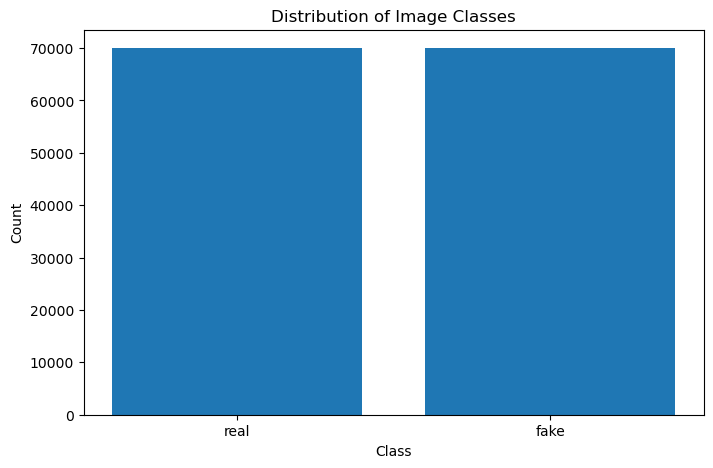

In [6]:
status_counts = dataset["img_status"].value_counts()
plt.figure(figsize=(8, 5))
plt.bar(status_counts.index, status_counts)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Distribution of Image Classes")
plt.show()

###### Loading the image

In [7]:
def load_image(dataset, img_status):
    plt.figure(figsize=(20, 10))

    # Path of the image
    images = dataset[dataset['img_status'] == img_status].sample(4)

    for i in range(4):
        plt.subplot(2, 4, i+1)
        plt.imshow(plt.imread(images["image_path"].values[i]))
        # Img_status
        plt.title(img_status, size=10)
        plt.xticks([])
        plt.yticks([])

    plt.show()

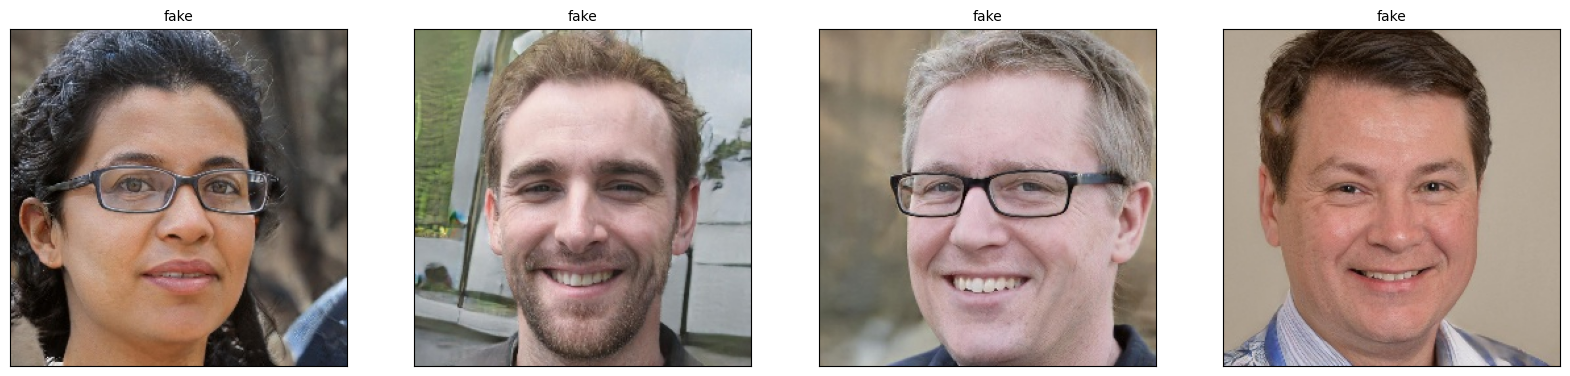

In [8]:
load_image(dataset, "fake")

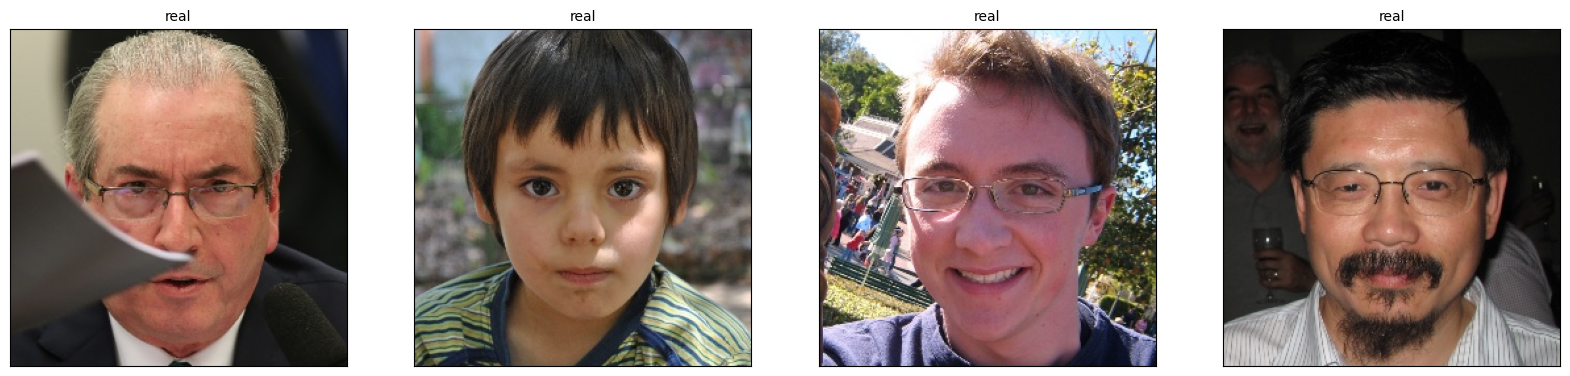

In [9]:
load_image(dataset, "real")

##### Getting the Face Location in the Image

##### Locating the face landmarks in the images

##### Add Padding to the images

##### Checking whether GPU is available or not

In [10]:
# If device is "cuda" then GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print (f"Device: {device}")

Device: cuda


##### Data Augmentation
Before proceeding with model training, the data underwent augmentation in order to increase the variability within them. This allows to obtain a model that is more generalized and robust

In [11]:
# Data Augmentation for Training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Data Transformation for Validation and Testing
val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Data Loaders
train_dataset = ImageFolder(os.path.join(config.dataset_path, 'train'), transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)

valid_dataset = ImageFolder(os.path.join(config.dataset_path, 'valid'), transform=val_test_transform)
valid_loader = DataLoader(valid_dataset, batch_size=config.batch_size, shuffle=False)

test_dataset = ImageFolder(os.path.join(config.dataset_path, 'test'), transform=val_test_transform)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

In [12]:
print("Train Dataset: ", train_dataset)
print("Train Loader: ", train_loader)

Train Dataset:  Dataset ImageFolder
    Number of datapoints: 100000
    Root location: /kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Train Loader:  <torch.utils.data.dataloader.DataLoader object at 0x7b47141ce560>


In [13]:
print("Valid Dataset: ", valid_dataset)
print("Valid Loader: ", valid_loader)

Valid Dataset:  Dataset ImageFolder
    Number of datapoints: 20000
    Root location: /kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Valid Loader:  <torch.utils.data.dataloader.DataLoader object at 0x7b458fa005e0>


In [14]:
print("Test Dataset: ", test_dataset)
print("Test Loader: ", test_loader)

Test Dataset:  Dataset ImageFolder
    Number of datapoints: 20000
    Root location: /kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test Loader:  <torch.utils.data.dataloader.DataLoader object at 0x7b458f9caa70>


##### Showing Augmented images

In [15]:
def show_augmented_images(loader):
    images, labels = next(iter(loader))

    label_names = ['Fake', 'Real']
    label_names = [label_names[label] for label in labels]

    fig, axes = plt.subplots(1, 5)
    axes = axes.ravel()

    for i in range(len(axes)):
        image = images[i].permute(1, 2, 0).cpu().numpy()  # Convert tensor to NumPy array
        image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]

        axes[i].imshow(image)
        axes[i].axis('off')

        label_index = labels[i].item()
        if label_index < len(label_names):  # Check if label index is within bounds
            label = label_names[label_index]
        else:
            label = "Unknown"
        axes[i].set_title(label)

    plt.tight_layout()
    plt.show()

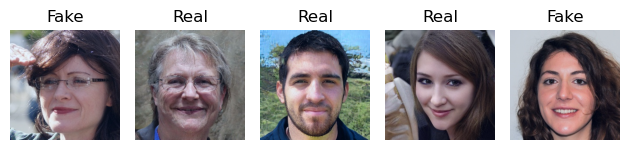

In [16]:
show_augmented_images(train_loader)

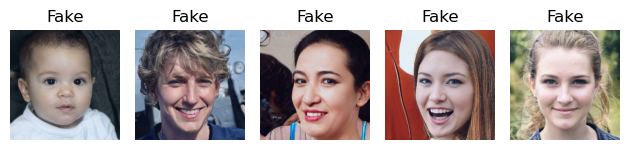

In [17]:
show_augmented_images(valid_loader)

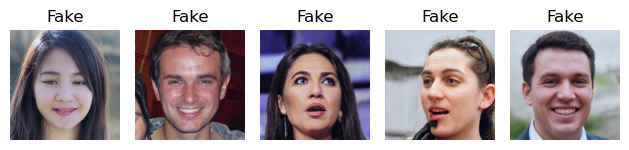

In [18]:
show_augmented_images(test_loader)

##### Custom Model Class - Pretrained = True
The CustomModel class defines a neural network model by extending nn.Module, utilizing a pretrained model architecture, replacing its fully connected layers, offering visualization, and summarizing its architecture and parameters.

In [19]:
class CustomModel(nn.Module):
    def __init__(self, model_name, num_classes):
        super(CustomModel, self).__init__()
        self.model = models.__dict__[model_name](pretrained=True)
        
        if 'vgg' in model_name:
            num_features = self.model.classifier[6].in_features
            self.model.classifier[6] = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, num_classes)
        )
            
        elif 'mobilenet' in model_name:
            num_features = self.model.classifier[1].in_features
            self.model.classifier = nn.Sequential(
                nn.Linear(num_features, 512),
                nn.ReLU(),
                nn.BatchNorm1d(512),
                nn.Linear(512, num_classes)
            )
            
        else:
            num_features = self.model.fc.in_features
            self.model.fc = nn.Sequential(
                nn.Linear(num_features, 512),
                nn.ReLU(),
                nn.BatchNorm1d(512),
                nn.Linear(512, num_classes)
            )
            
        self.val_loss = []
        self.val_accuracy = []
        self.train_loss = []
        self.train_accuracy = []

    def forward(self, x):
        return self.model(x)

    def print_model_summary(self):
        print(self.model)
        print("Model Summary:")
        total_params = sum(p.numel() for p in self.parameters())
        print(f"Total Parameters: {total_params}")
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"Trainable Parameters: {trainable_params}")

    def plot_metrics_graph(self):
        epochs = range(1, len(self.train_loss) + 1)

        plt.figure(figsize=(12, 8))

        plt.subplot(2, 1, 1)
        plt.plot(epochs, self.train_loss, label='Train Loss', linewidth=2, color='blue')
        plt.plot(epochs, self.val_loss, label='Validation Loss', linewidth=2, color='orange')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(epochs, self.train_accuracy, label='Train Accuracy', linewidth=2, color='green')
        plt.plot(epochs, self.val_accuracy, label='Validation Accuracy', linewidth=2, color='red')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Confusion Matrix")
        plt.show()

    def train_model(self, train_loader, valid_loader, num_epochs, device):
        criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy loss
        optimizer = optim.Adam(self.parameters(), lr=0.001)

        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, verbose=True, min_lr=1e-6)

        for epoch in range(num_epochs):
            self.train()  # Set the model to training mode
            total_loss = 0.0
            correct_train = 0
            total_train = 0

            print(f"Epoch [{epoch+1}/{num_epochs}] - Training...")

            for batch_idx, (inputs, labels) in enumerate(train_loader):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels.float().unsqueeze(1))
                loss.backward()
                optimizer.step()

                total_loss += loss.item() * inputs.size(0)
                predicted_labels = (outputs >= 0.0).float()
                correct_train += (predicted_labels == labels.float().unsqueeze(1)).sum().item()
                total_train += labels.size(0)

                print(f"Epoch [{epoch+1}/{num_epochs}] - Batch [{batch_idx+1}/{len(train_loader)}] - "
                      f"Loss: {loss.item():.4f} - Train Accuracy: {correct_train / total_train:.4f}")

            average_loss = total_loss / len(train_loader.dataset)
            train_accuracy = correct_train / total_train

            self.train_loss.append(average_loss)
            self.train_accuracy.append(train_accuracy)

            self.eval()
            total_val_loss = 0.0
            correct_val = 0
            total_val = 0

            y_true = []
            y_pred = []

            with torch.no_grad():
                for inputs, labels in valid_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = self(inputs)
                    val_loss = criterion(outputs, labels.float().unsqueeze(1))
                    total_val_loss += val_loss.item() * inputs.size(0)
                    predicted_labels = (outputs >= 0.0).float()
                    correct_val += (predicted_labels == labels.float().unsqueeze(1)).sum().item()
                    total_val += labels.size(0)

                    y_true.extend(labels.float().unsqueeze(1).cpu().numpy())
                    y_pred.extend(predicted_labels.cpu().numpy())

            average_val_loss = total_val_loss / len(valid_loader.dataset)
            val_accuracy = correct_val / total_val

            self.val_loss.append(average_val_loss)
            self.val_accuracy.append(val_accuracy)

            print(f"Epoch [{epoch+1}/{num_epochs}] - "
                  f"Train Loss: {average_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - "
                  f"Val Loss: {average_val_loss:.4f} - Val Accuracy: {val_accuracy:.4f} - "
                  f"LR: {scheduler.optimizer.param_groups[0]['lr']:.6f}")

            scheduler.step(average_val_loss)
        
        self.plot_metrics_graph()
        self.plot_confusion_matrix(y_true, y_pred)

##### Resnet 50 Implemenation

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 187MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [1/5] - Training...
Epoch [1/5] - Batch [1/1563] - Loss: 0.7553 - Train Accuracy: 0.4688
Epoch [1/5] - Batch [2/1563] - Loss: 0.6208 - Train Accuracy: 0.5938
Epoch [1/5] - Batch [3/1563] - Loss: 0.6930 - Train Accuracy: 0.6406
Epoch [1/5] - Batch [4/1563] - Loss: 0.8508 - Train Accuracy: 0.6328
Epoch [1/5] - Batch [5/1563] - Loss: 0.5656 - Train Accuracy: 0.6562
Epoch [1/5] - Batch [6/1563] - Loss: 0.6996 - Train Accuracy: 0.6589
Epoch [1/5] - Batch [7/1563] - Loss: 0.5597 - Train Accuracy: 0.6741
Epoch [1/5] - Batch [8/1563] - Loss: 0.6534 - Train Accuracy: 0.6719
Epoch [1/5] - Batch [9/1563] - Loss: 0.4120 - Train Accuracy: 0.6858
Epoch [1/5] - Batch [10/1563] - Loss: 0.5337 - Train Accuracy: 0.6937
Epoch [1/5] - Batch [11/1563] - Loss: 0.7758 - Train Accuracy: 0.6946
Epoch [1/5] - Batch [12/1563] - Loss: 0.5136 - Train Accuracy: 0.7031
Epoch [1/5] - Batch [13/1563] - Loss: 0.5219 - Train Accuracy: 0.7055
Epoch [1/5] - Batch [14/1563] - Loss: 0.6284 - Train Accuracy: 0.7065
Epo

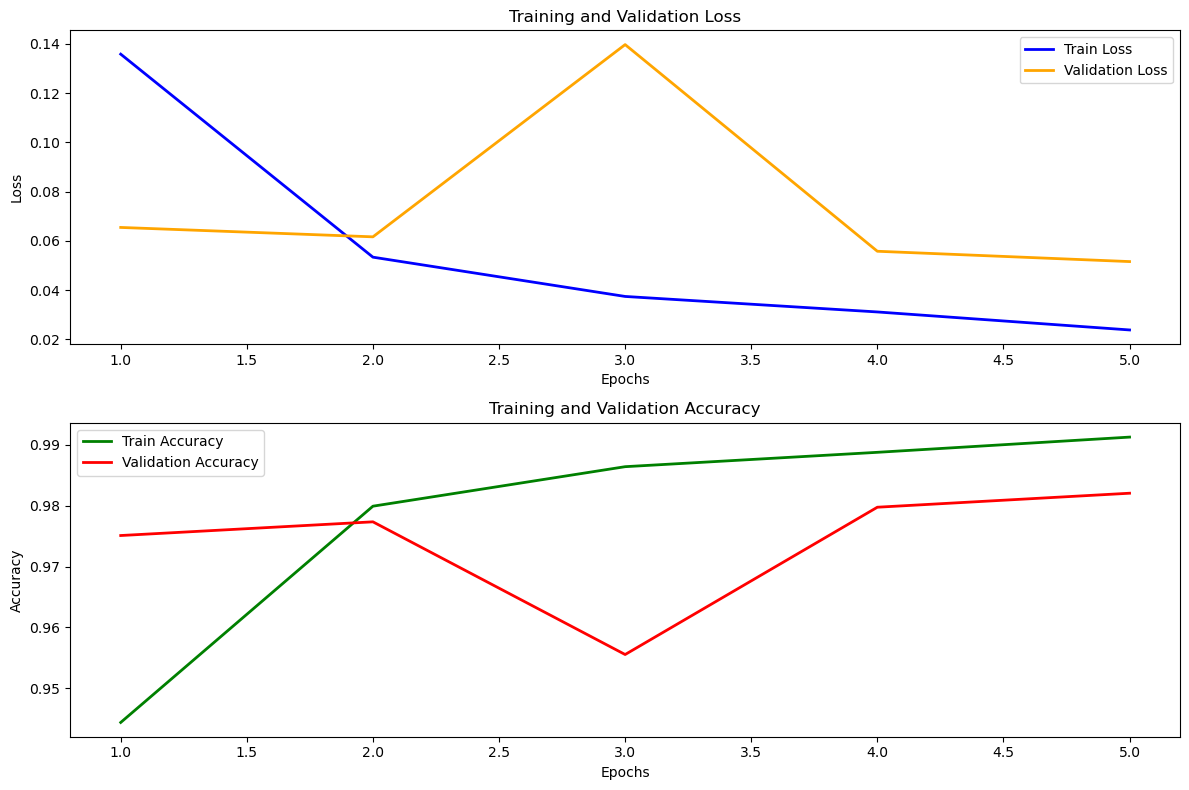

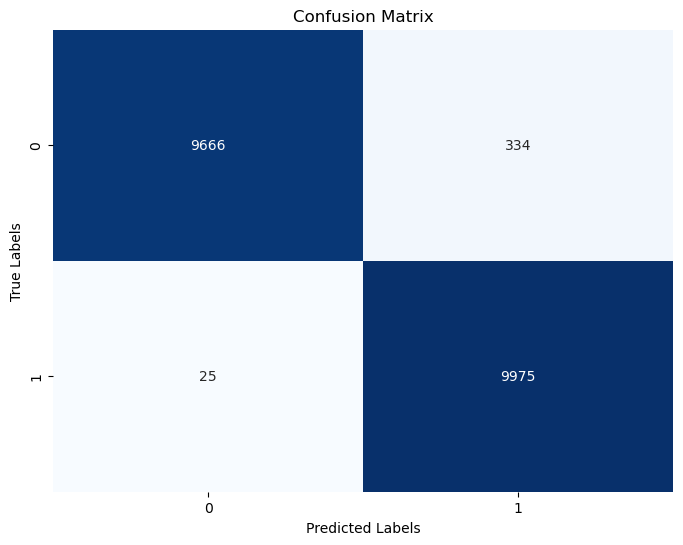

In [21]:
# Train the model using the integrated training loop
num_epochs = config.epoch # Change this in last
model.train_model(train_loader, valid_loader, num_epochs, device)

In [22]:
torch.cuda.empty_cache()


In [23]:
torch.save(model.state_dict(), 'model-resnet18.pth')